In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
flood = pd.read_csv("/content/drive/MyDrive/flood.csv") # Reading out the flood data.csv

In [ ]:
flood['Date'] = pd.to_datetime(flood['Date'])

In [ ]:
len(flood[flood['Waterlevel'] <= 0]) # There are 6 rows that has value of waterlevel less than 0

7

In [ ]:
filtered_data = flood[flood['Waterlevel'] <= 0]
filtered_data

,Date,Discharge,Waterlevel,Precipitation,max_temperature,min_temperature,max_humidity,min_humidity
365,2000-12-31,33.0,0.00,0.0,20.1,7.6,95.2,91.2
730,2001-12-31,29.4,-0.35,0.0,21.2,3.2,91.2,74.3
1095,2002-12-31,25.2,-0.37,0.0,18.5,6.0,90.2,95.2
1460,2003-12-31,36.6,-0.31,0.0,19.7,5.1,98.5,61.8
1826,2004-12-31,30.6,-0.02,0.0,17.6,7.8,90.0,59.6
2191,2005-12-31,35.3,-0.32,0.0,22.4,6.0,100.0,48.1
2556,2006-12-31,14.8,-0.35,0.0,21.6,5.6,98.6,52.2


In [ ]:
filtered_dis_data = flood[(flood['Discharge'] > 14) & (flood['Discharge']<34)]

In [ ]:
filtered_dis_data['Waterlevel'].mean()

0.8772059369202225

In [ ]:
flood.loc[flood['Waterlevel'] <= 0, 'Waterlevel'] = 0.88

In [ ]:
len(flood[flood['Waterlevel'] <= 0])

0

In [ ]:
flood['Month'] = flood['Date'].dt.month

In [ ]:
flood3 = flood[(flood['Month']>=6) & (flood['Month']<=9)]

In [ ]:
flood3.shape

(2440, 9)

In [ ]:
df = flood3.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [ ]:
df = df.rolling(window=3).mean().dropna()

In [ ]:
df = df.reset_index()

In [ ]:
# Step 1: Split the data into training (2000-2015) and testing (2016-2019)
train_data = df[(df['Date'].dt.year >= 2000) & (df['Date'].dt.year <= 2015)]
test_data = df[(df['Date'].dt.year >= 2016) & (df['Date'].dt.year <= 2019)]

# Step 2: Extract the features (X) and labels (y) for both training and testing sets
X_train = train_data[['Precipitation','Waterlevel', 'max_temperature', 'min_temperature', 'max_humidity', 'min_humidity']]
y_train = train_data[['Discharge']]

X_test = test_data[['Precipitation','Waterlevel', 'max_temperature', 'min_temperature', 'max_humidity', 'min_humidity']]
y_test = test_data[['Discharge']]

In [ ]:
# Print the shape of the datasets to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (1950, 6), y_train shape: (1950, 1)
X_test shape: (488, 6), y_test shape: (488, 1)


In [ ]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

In [ ]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [ ]:
# Fit and transform the target data
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:
# Reshape the data for LSTM input
X_train_reshaped = np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_reshaped = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, GRU,LSTM, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Define GRU model with Dropout
lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(32, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(16, activation='relu'))
lstm_model.add(Dense(1, activation='linear'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile GRU model
lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

# Train GRU model with early stopping
lstm_history = lstm_model.fit(X_train_reshaped, y_train_scaled, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0095 - mae: 0.0721 - val_loss: 0.0126 - val_mae: 0.0726
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0061 - mae: 0.0590 - val_loss: 0.0082 - val_mae: 0.0548
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0460 - val_loss: 0.0048 - val_mae: 0.0427
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0443 - val_loss: 0.0045 - val_mae: 0.0439
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0039 - mae: 0.0416 - val_loss: 0.0048 - val_mae: 0.0431
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - mae: 0.0417 - val_loss: 0.0046 - val_mae: 0.0420
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0435 - val_loss: 0.0043 - val_mae: 0.0424
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0435 - val_loss: 0.0052 - val_mae: 0.0489
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0

In [ ]:
# Make predictions
predictions_scaled = lstm_model.predict(X_test_reshaped)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
# Inverse transform the predictions
predictions = scaler_y.inverse_transform(predictions_scaled)

In [ ]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

In [ ]:
print("MSE/= ", mse)
print("MAE/= ", mae)

MSE/=  7561.67221029961
MAE/=  44.61233651833455


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# After making predictions (predictions are already rescaled)
predictions = scaler_y.inverse_transform(predictions_scaled)

# Calculate R-Squared
r2 = r2_score(y_test, predictions)
print(f"R-Squared: {r2}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

# Calculate NSE
nse = 1 - (np.sum((y_test - predictions) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))
print(f"NSE: {nse}")

R-Squared: 0.8477249042527235
RMSE: 86.95787606824128
NSE: Discharge    0.847725
dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
results_by_year = []

for year in range(2016, 2020):  # Loop over each year from 2016 to 2019
    yearly_test_data = test_data[test_data['Date'].dt.year == year]
    X_year = yearly_test_data[['Precipitation','Waterlevel', 'max_temperature', 'min_temperature', 'max_humidity', 'min_humidity']]
    y_year = yearly_test_data[['Discharge']]

    # Scale the test data for the current year
    X_year_scaled = scaler_X.transform(X_year)
    y_year_scaled = scaler_y.transform(y_year)

    # Reshape for GRU input
    X_year_reshaped = np.reshape(X_year_scaled, (X_year_scaled.shape[0], X_year_scaled.shape[1], 1))

    # Make predictions
    predictions_scaled = lstm_model.predict(X_year_reshaped)
    predictions = scaler_y.inverse_transform(predictions_scaled)  # Rescale back to original scale

    # Calculate Metrics
    r2 = r2_score(y_year, predictions)
    rmse = np.sqrt(mean_squared_error(y_year, predictions))
    nse = 1 - (np.sum((y_year.values - predictions) ** 2) / np.sum((y_year.values - np.mean(y_year.values)) ** 2))

    # You can calculate additional metrics such as PBIAS, RSR, etc.
    pbias = 100 * np.sum(y_year.values - predictions) / np.sum(y_year.values)
    rsr = rmse / np.std(y_year.values)

    # Store the results for each year
    results_by_year.append({
        "Year": year,
        "R²": r2,
        "RMSE": rmse,
        "NSE": nse,
        "PBIAS": pbias,
        "RSR": rsr
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results_by_year)

# Display the evaluation metrics for each year
print(results_df)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
   Year        R²       RMSE       NSE      PBIAS       RSR
0  2016  0.888486  95.568068  0.888486   5.079752  0.333937
1  2017  0.847215  92.535170  0.847215  -5.670687  0.390877
2  2018  0.705744  87.403671  0.705744 -10.336229  0.542453
3  2019  0.839547  70.080483  0.839547  -4.809714  0.400566


In [ ]:
results_by_year_training = []

for year in range(2000, 2016):  # Loop over each year from 2000 to 2015
    yearly_train_data = train_data[train_data['Date'].dt.year == year]
    X_year = yearly_train_data[['Precipitation','Waterlevel', 'max_temperature', 'min_temperature', 'max_humidity', 'min_humidity']]
    y_year = yearly_train_data[['Discharge']]

    # Scale the test data for the current year
    X_year_scaled = scaler_X.transform(X_year)
    y_year_scaled = scaler_y.transform(y_year)

    # Reshape for GRU input
    X_year_reshaped = np.reshape(X_year_scaled, (X_year_scaled.shape[0], X_year_scaled.shape[1], 1))

    # Make predictions
    predictions_scaled = lstm_model.predict(X_year_reshaped)
    predictions = scaler_y.inverse_transform(predictions_scaled)  # Rescale back to original scale

    # Calculate Metrics
    r2 = r2_score(y_year, predictions)
    rmse = np.sqrt(mean_squared_error(y_year, predictions))
    nse = 1 - (np.sum((y_year.values - predictions) ** 2) / np.sum((y_year.values - np.mean(y_year.values)) ** 2))

    # You can calculate additional metrics such as PBIAS, RSR, etc.
    pbias = 100 * np.sum(y_year.values - predictions) / np.sum(y_year.values)
    rsr = rmse / np.std(y_year.values)

    # Store the results for each year
    results_by_year_training.append({
        "Year": year,
        "R²": r2,
        "RMSE": rmse,
        "NSE": nse,
        "PBIAS": pbias,
        "RSR": rsr
    })

# Convert results to DataFrame
results_df_training = pd.DataFrame(results_by_year_training)

# Display the evaluation metrics for each year (2000 to 2015)
print(results_df_training)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
    Year        R²        RMSE       NSE      PBIAS       RSR
0   2000  0.816784  170.871218  0.816784  11.356910  0.428038
1   2001  0.932513   68.774589  0.932513   6.730655  0.259782
2   2002  0.787066   70.268030  0.787066  10.568816  0.461447
3   2003  0.846637  104.409068  0.846637  12.239871  0.391616
4   2004  0.655166   69.068725  0.655166  19.363947  0.587226
5   2005  0.924182  

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<ipython-input-33-7b019935ff87>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Observed_Discharge'] = actual_discharge_test
<ipython-input-33-7b019935ff87>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Simulated_Discharge'] = predicted_discharge_test


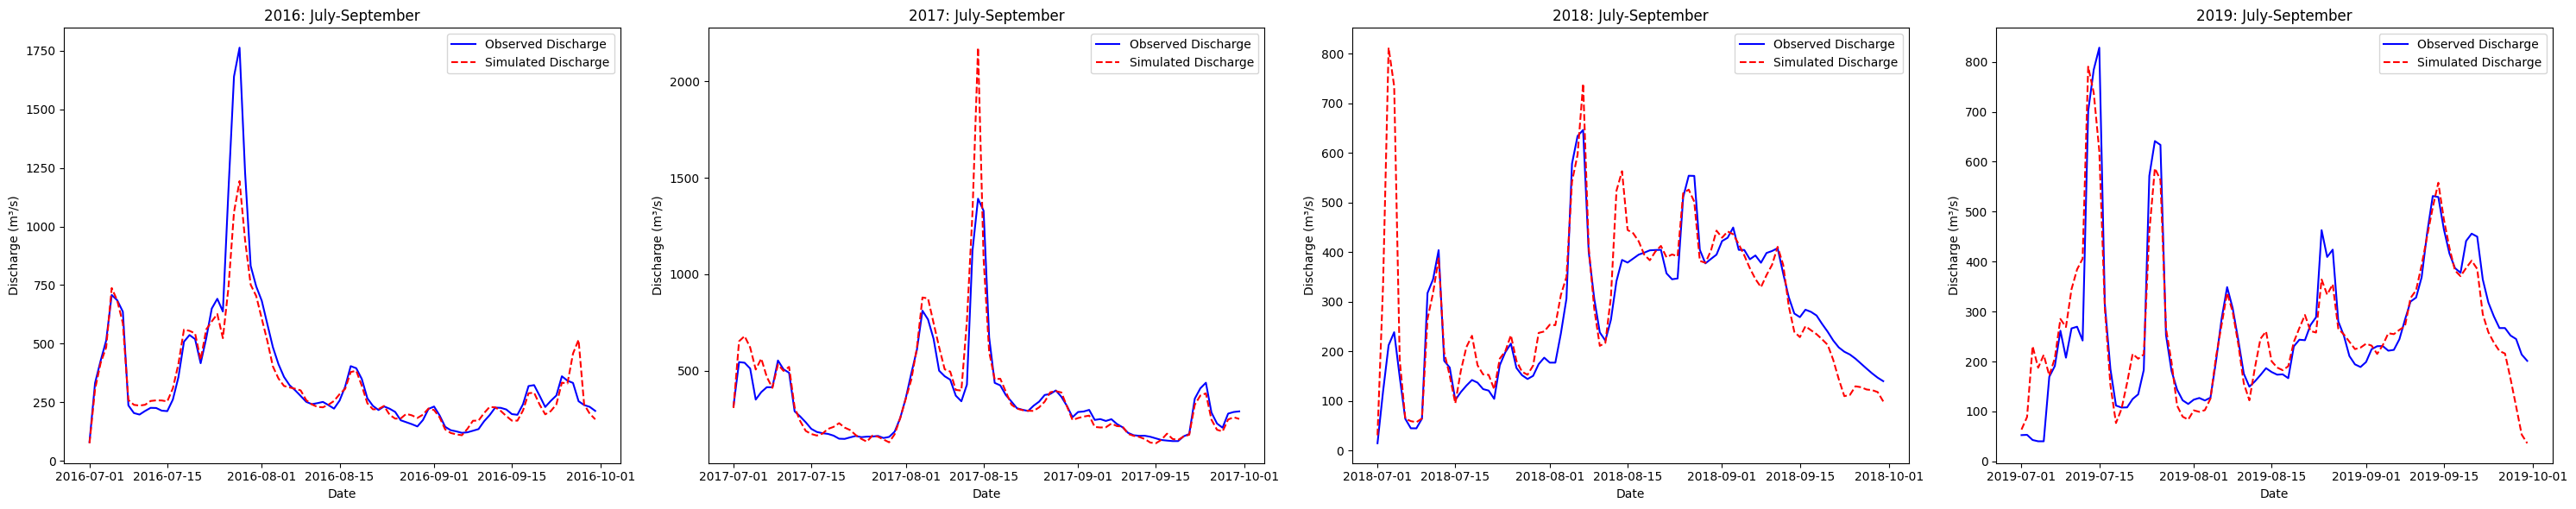

In [ ]:
# Step 1: Prepare the actual (observed) and predicted discharge data for the test set (2016-2019)
actual_discharge_test = y_test.values  # Observed discharge in test data
predicted_discharge_test_scaled = lstm_model.predict(X_test_reshaped)  # Simulated discharge for test set
predicted_discharge_test = scaler_y.inverse_transform(predicted_discharge_test_scaled)  # Inverse transform to original scale

# Step 2: Create a dataframe for the test data with discharge data
test_data['Observed_Discharge'] = actual_discharge_test
test_data['Simulated_Discharge'] = predicted_discharge_test

# Step 3: Define the function to plot test data for July to September (2016-2019)
def plot_discharge_july_september(data):
    years = [2016, 2017, 2018, 2019]  # Define the years of interest
    fig, axes = plt.subplots(1, len(years), figsize=(30, 6))  # Create a row of subplots, one for each year

    for i, year in enumerate(years):
        # Filter data for the current year and the months July to September (7, 8, 9)
        year_data = data[(data['Date'].dt.year == year) & (data['Date'].dt.month >= 7) & (data['Date'].dt.month <= 9)]

        # Plot observed vs simulated discharge for July to September of the current year
        ax = axes[i]
        ax.plot(year_data['Date'], year_data['Observed_Discharge'], color='blue', label='Observed Discharge')
        ax.plot(year_data['Date'], year_data['Simulated_Discharge'], color='red', linestyle='--', label='Simulated Discharge')

        # Set titles and labels
        ax.set_title(f'{year}: July-September')
        ax.set_ylabel('Discharge (m³/s)')
        ax.set_xlabel('Date')
        ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Step 4: Call the function to create the plot
plot_discharge_july_september(test_data)

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<ipython-input-34-d11d632a0706>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Observed_Discharge'] = actual_discharge_train
<ipython-input-34-d11d632a0706>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Simulated_Discharge'] = predicted_discharge_train


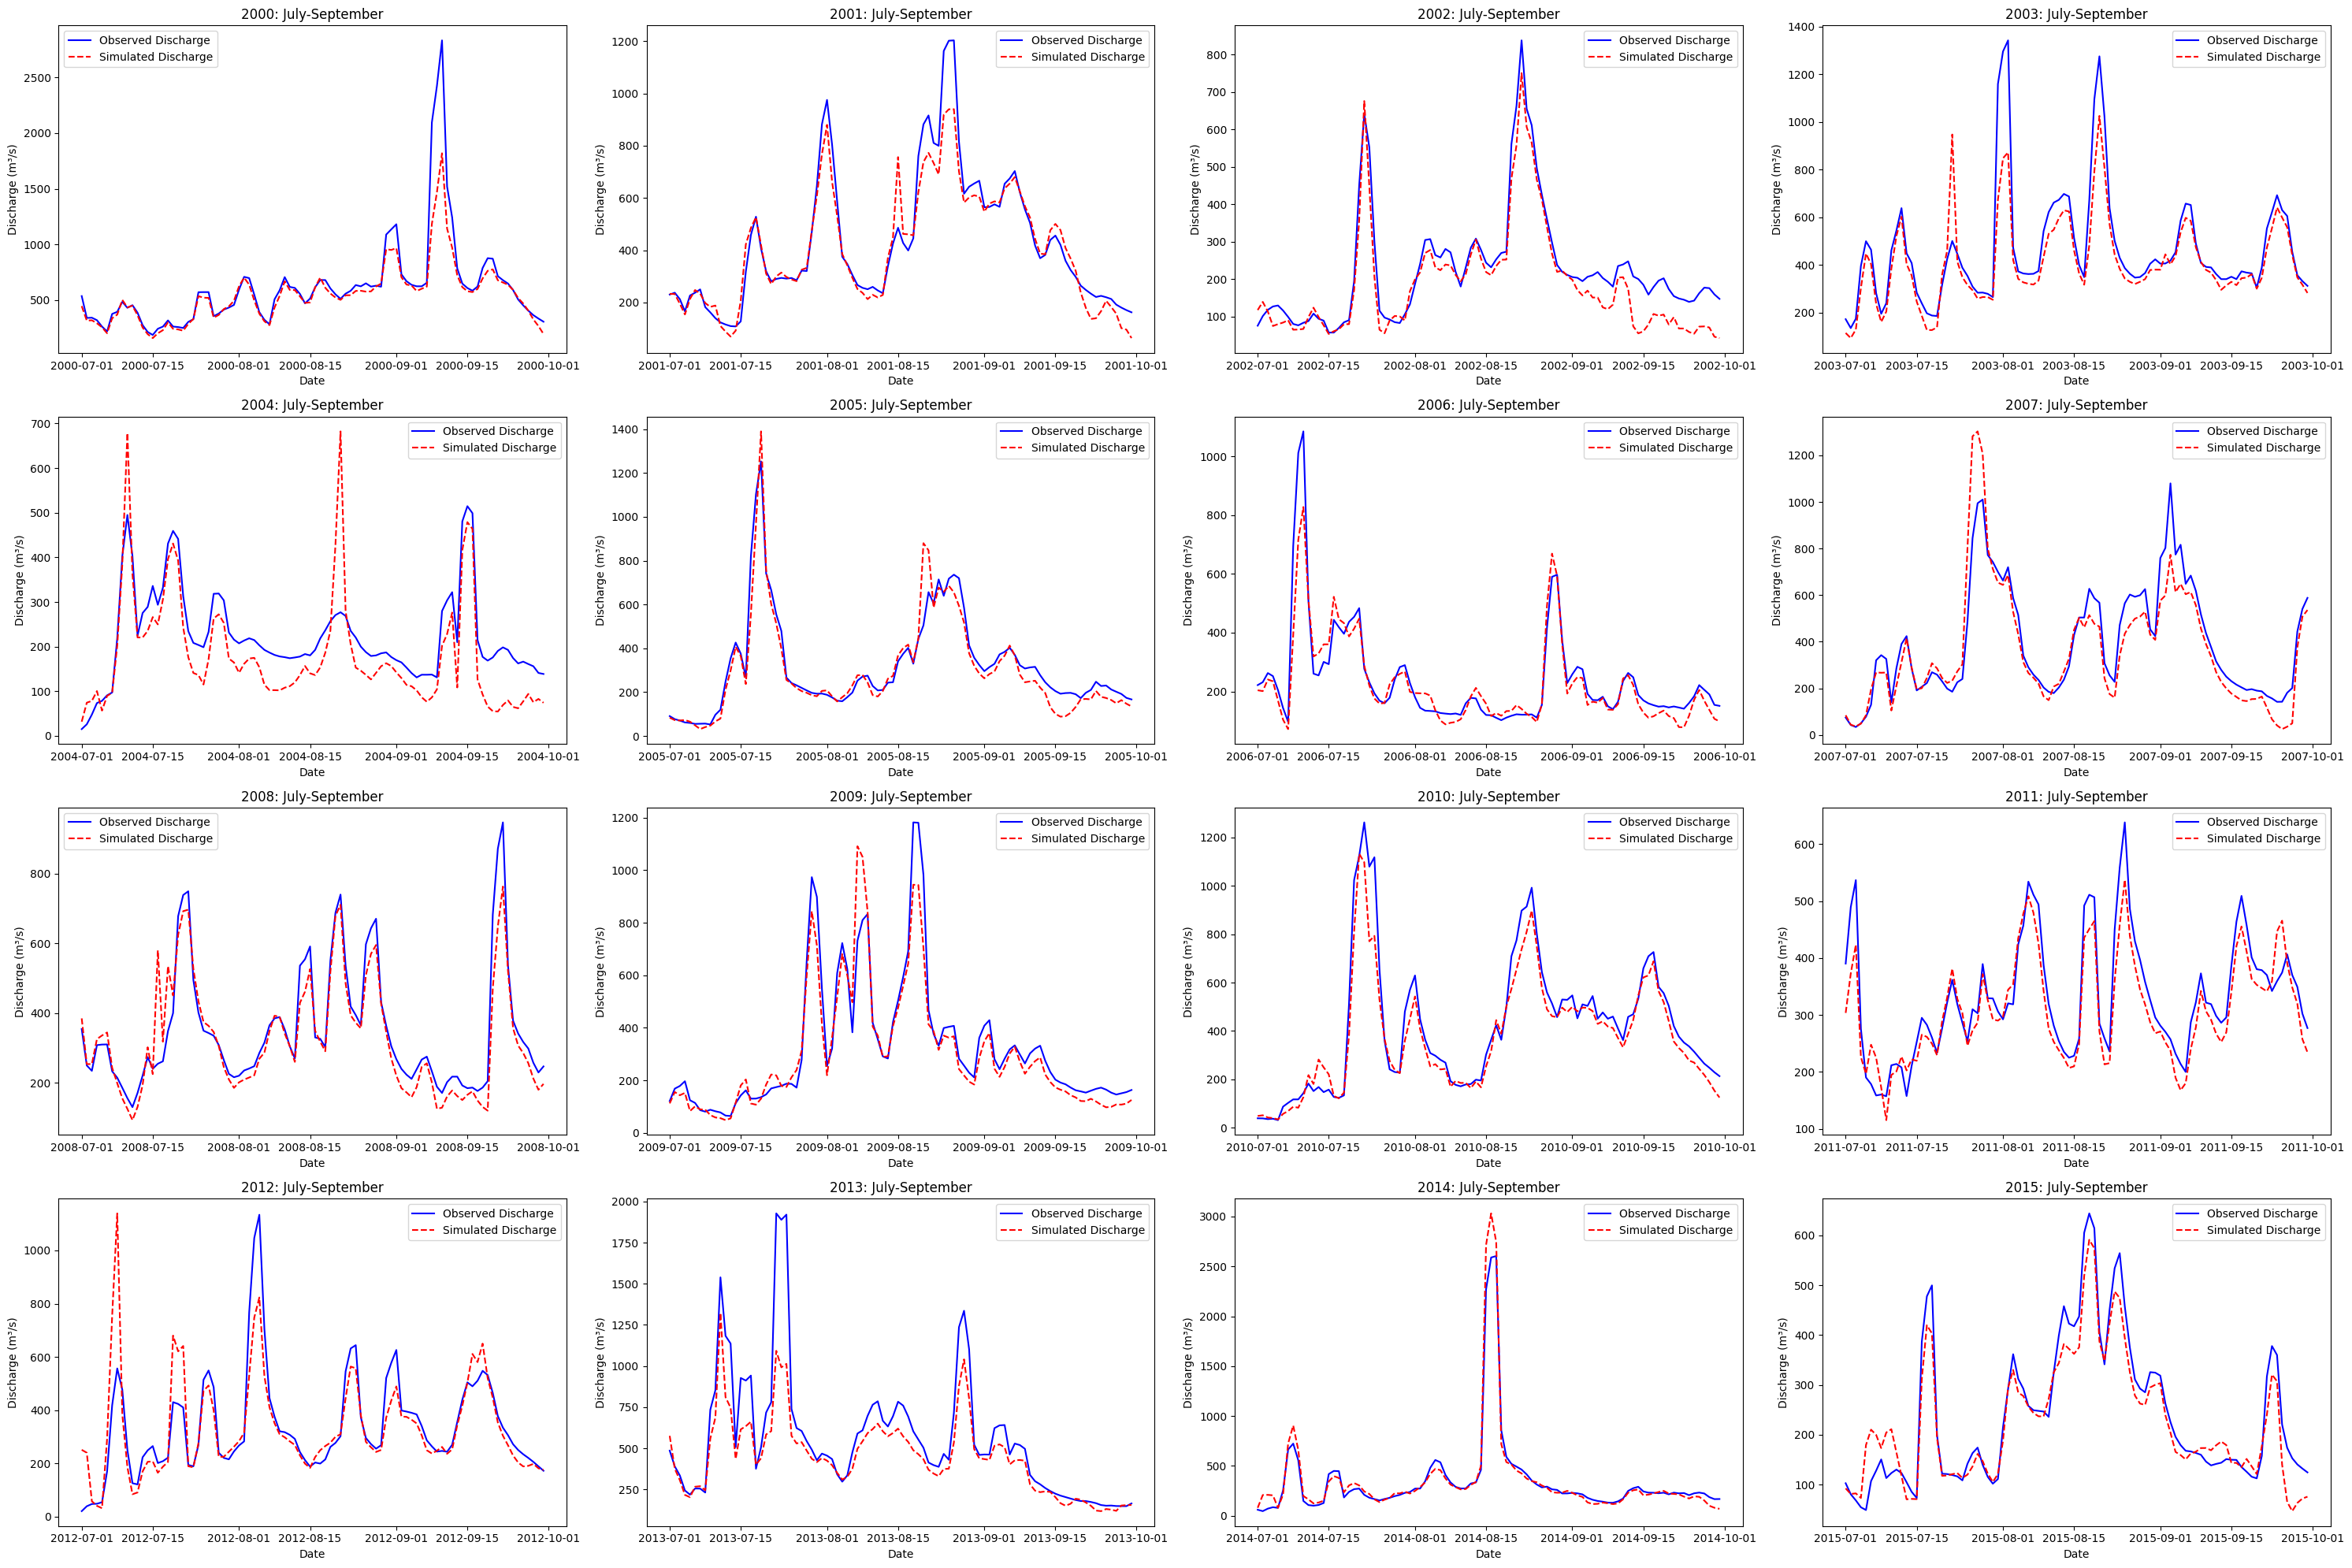

In [ ]:
# Step 1: Prepare the actual (observed) and predicted discharge data for the training set (2000-2015)
actual_discharge_train = y_train.values  # Observed discharge in training data
predicted_discharge_train_scaled = lstm_model.predict(X_train_reshaped)  # Simulated discharge for training set
predicted_discharge_train = scaler_y.inverse_transform(predicted_discharge_train_scaled)  # Inverse transform to original scale

# Step 2: Create a dataframe for the training data with discharge data
train_data['Observed_Discharge'] = actual_discharge_train
train_data['Simulated_Discharge'] = predicted_discharge_train

# Step 3: Define the function to plot training data for July to September (2000-2015)
def plot_discharge_july_september_train(data):
    years = range(2000, 2016)  # Define the years of interest
    fig, axes = plt.subplots(4, 4, figsize=(30, 20))  # Create a grid of subplots (4x4) for each year

    for i, year in enumerate(years):
        # Filter data for the current year and the months July to September (7, 8, 9)
        year_data = data[(data['Date'].dt.year == year) & (data['Date'].dt.month >= 7) & (data['Date'].dt.month <= 9)]

        # Calculate the row and column indices for the subplot grid
        row = i // 4
        col = i % 4

        # Plot observed vs simulated discharge for July to September of the current year
        ax = axes[row, col]
        ax.plot(year_data['Date'], year_data['Observed_Discharge'], color='blue', label='Observed Discharge')
        ax.plot(year_data['Date'], year_data['Simulated_Discharge'], color='red', linestyle='--', label='Simulated Discharge')

        # Set titles and labels
        ax.set_title(f'{year}: July-September')
        ax.set_ylabel('Discharge (m³/s)')
        ax.set_xlabel('Date')
        ax.legend()

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Step 4: Call the function to create the plot for training data
plot_discharge_july_september_train(train_data)